# Import Libraries

In [53]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms

from torchvision.models import (
    resnet50, vgg16, efficientnet_b0, mobilenet_v2, shufflenet_v2_x0_5, squeezenet1_0)

from torchvision.models import (
    ResNet50_Weights, VGG16_Weights, EfficientNet_B0_Weights, MobileNet_V2_Weights,
    ShuffleNet_V2_X0_5_Weights, SqueezeNet1_0_Weights)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
import tensorflow as tf
import tensorflow_hub as hub
# from efficientnet_lite import EfficientNetLiteB0
from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
%matplotlib inline

## Test Tensorflow-CPU

In [54]:
# import tensorflow as tf

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU


# print("Available devices:")
# for device in tf.config.list_physical_devices():
#     print(device)

In [55]:
# import logging
# import tensorflow as tf
# import os

# # Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# # Configure TensorFlow logging
# logging.getLogger("tensorflow").setLevel(logging.DEBUG)
# tf.debugging.set_log_device_placement(True)

# # Perform a computation
# a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
# b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
# c = tf.matmul(a, b)
# print(c)


In [56]:

# print(tf.__version__)


# Visualization

In [57]:
# Function to display an image
def show_image(image_path, title="Image"):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Function to display grayscale images
def show_grayscale_image(image, title="Grayscale Image"):
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Function to display SIFT matches
def show_sift_matches(image1_path, image2_path, kp1, kp2, matches):
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    match_img = cv2.drawMatches(
        img1, kp1, img2, kp2, matches[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(match_img)
    plt.title("SIFT Matches")
    plt.axis("off")
    plt.show()


# Calculate SSIM and SIFT

In [58]:
# Compute SSIM
def compute_ssim(image1_path, image2_path):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize to ensure consistent dimensions
    img1 = cv2.resize(img1, (256, 256))
    img2 = cv2.resize(img2, (256, 256))
    
    # show_grayscale_image(img1, title="Grayscale Image 1 for SSIM")
    # show_grayscale_image(img2, title="Grayscale Image 2 for SSIM")
    
    similarity, _ = ssim(img1, img2, full=True)
    return similarity

# Compute SIFT Matches
def sift_similarity(image1_path, image2_path):
    sift = cv2.SIFT_create()
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    if des1 is None or des2 is None:
        return 0, 0, 0, [], [], []
    
    # Match descriptors using FLANN
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    return len(good_matches), len(kp1), len(kp2), kp1, kp2, good_matches


def compute_cosine_similarity(features1, features2):
    return 1 - cosine(features1, features2)



## Preprocessing on Deep Learning Models

In [59]:
# Define the transformation pipeline
pytorch_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess image for PyTorch
def preprocess_pytorch_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = pytorch_transform(img).unsqueeze(0)
    return img


def preprocess_tf_image(image_path, target_size=(224, 224)):

    # Load and convert the image
    img = cv2.imread(image_path)  # Load image in BGR format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Resize to target size (224x224)
    img = cv2.resize(img, target_size)

    # Normalize pixel values to [0, 1] range
    img = img / 255.0

    # Add batch dimension: shape (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0).astype(np.float32)

    return img

## Define Deep Learning Models

In [60]:
# Load pretrained models
def load_models():
    # PyTorch models
    pytorch_models = {
        "ResNet50": resnet50(weights=ResNet50_Weights.DEFAULT),
        "VGG16": vgg16(weights=VGG16_Weights.DEFAULT),
        "EfficientNet_B0": efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT),
        "MobileNet": mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT),
        "ShuffleNet": shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.DEFAULT),
        "SqueezeNet": squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT),
    }
    
    # TensorFlow EfficientNet-Lite model from TensorFlow Hub
    efficientnet_lite_b0 = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2",
        trainable=False  # Ensure the model is in inference mode
    )
    
    tf_models = {
        "EfficientNet-Lite": efficientnet_lite_b0
    }
    
    return pytorch_models, tf_models

# Call load_models to initialize both PyTorch and TensorFlow models
pytorch_models, tf_models = load_models()

## Compute Similarity through DLs

In [61]:
# Extract features and compute cosine similarity
def compute_similarity(img1_path, img2_path, pytorch_models, tf_models, pytorch_transform):
    print("\n### PyTorch Models ###")
    for name, model in pytorch_models.items():
        model.eval()
        with torch.no_grad():
            # Preprocess images
            img1 = preprocess_pytorch_image(img1_path)
            img2 = preprocess_pytorch_image(img2_path)
            # img1 = preprocess_pytorch_image(img1_path, pytorch_transform)
            # img2 = preprocess_pytorch_image(img2_path, pytorch_transform)
            # Extract features
            features1 = model(img1).squeeze().numpy()
            features2 = model(img2).squeeze().numpy()

            # Compute cosine similarity
            similarity = compute_cosine_similarity(features1, features2)
            print(f"{name} Cosine Similarity: {similarity:.4f}")

    print("\n### TensorFlow Models ###")
    for name, model in tf_models.items():
        # Preprocess images
        img1 = preprocess_tf_image(img1_path)
        img2 = preprocess_tf_image(img2_path)

        # # Debugging prints
        # print(f"{name}: Image 1 Shape: {img1.shape}, Dtype: {img1.dtype}")
        # print(f"{name}: Image 2 Shape: {img2.shape}, Dtype: {img2.dtype}")

        # Extract features
        features1 = model(img1, training=False).numpy().flatten()  # Ensure training=False
        features2 = model(img2, training=False).numpy().flatten()

        # Compute cosine similarity
        similarity = compute_cosine_similarity(features1, features2)
        print(f"{name} Cosine Similarity: {similarity:.4f}")


# Example Paths

# Get Valid images and the input

In [62]:
# img1= 'bankmellat_pic3.jpeg'
# img2 = 'bankghavamin_pic7.jpg'
img1= 'BM_LOGO-01.png' 
# img2= 'banktejarat_pic8.png'
# img1= 'cat.jpg'
# img2= 'flower.jpg'
# img1 = 'mellal.png'
# img2 = 'bankmellat_pic6.jpeg'
# img2= 'bankmellat_pic5.png'

valid_img = ['BM_LOGO-00.png' , 'BM_LOGO-01.png' ,  'BM_LOGO-02.png' , 'BM_LOGO-03.png' , 'BM_LOGO-04.png', 'BM_LOGO-05.png']

# Results

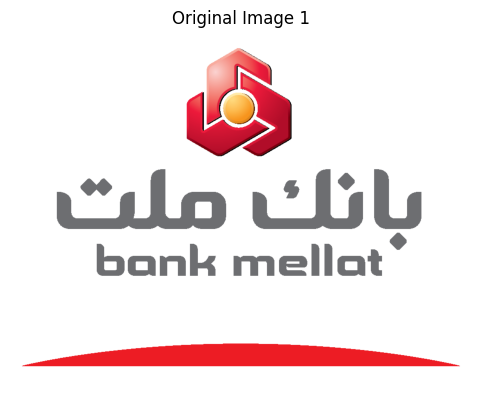

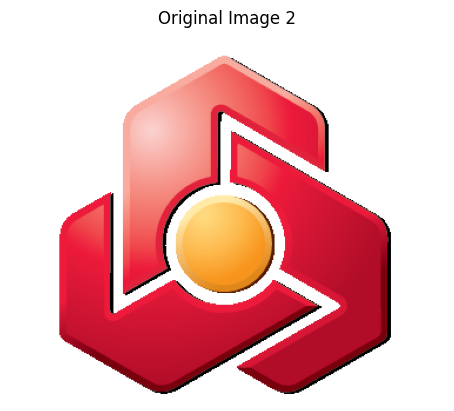

considered picture BM_LOGO-01.png compare with BM_LOGO-00.png
Results:

### PyTorch Models ###
ResNet50 Cosine Similarity: 0.5351
VGG16 Cosine Similarity: 0.7618
EfficientNet_B0 Cosine Similarity: 0.4139
MobileNet Cosine Similarity: 0.5394
ShuffleNet Cosine Similarity: 0.4364
SqueezeNet Cosine Similarity: 0.9472

### TensorFlow Models ###
EfficientNet-Lite Cosine Similarity: 0.3832
SIFT Match Ratio: 0.4512
SSIM Score: 0.5193


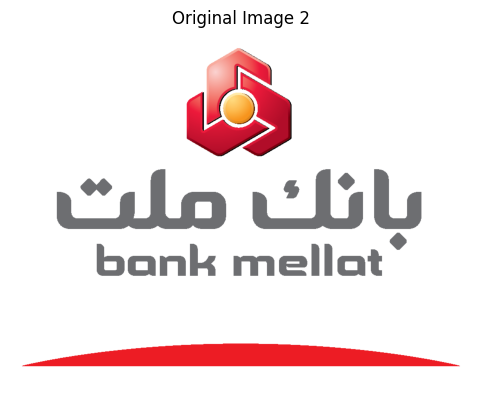

considered picture BM_LOGO-01.png compare with BM_LOGO-01.png
Results:

### PyTorch Models ###
ResNet50 Cosine Similarity: 1.0000
VGG16 Cosine Similarity: 1.0000
EfficientNet_B0 Cosine Similarity: 1.0000
MobileNet Cosine Similarity: 1.0000
ShuffleNet Cosine Similarity: 1.0000
SqueezeNet Cosine Similarity: 1.0000

### TensorFlow Models ###
EfficientNet-Lite Cosine Similarity: 1.0000
SIFT Match Ratio: 0.9489
SSIM Score: 1.0000


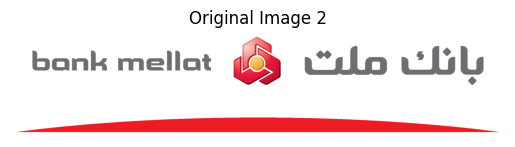

considered picture BM_LOGO-01.png compare with BM_LOGO-02.png
Results:

### PyTorch Models ###
ResNet50 Cosine Similarity: 0.7616
VGG16 Cosine Similarity: 0.7874
EfficientNet_B0 Cosine Similarity: 0.6397
MobileNet Cosine Similarity: 0.7125
ShuffleNet Cosine Similarity: 0.7181
SqueezeNet Cosine Similarity: 0.9640

### TensorFlow Models ###
EfficientNet-Lite Cosine Similarity: 0.6269
SIFT Match Ratio: 0.5176
SSIM Score: 0.5401


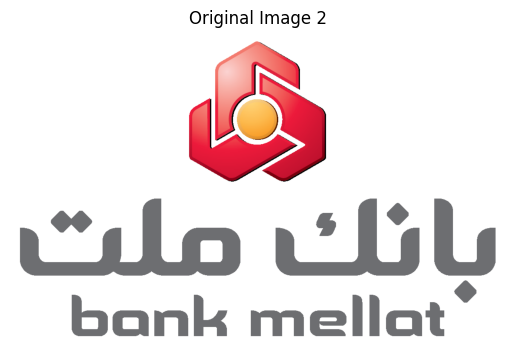

considered picture BM_LOGO-01.png compare with BM_LOGO-03.png
Results:

### PyTorch Models ###
ResNet50 Cosine Similarity: 0.8074
VGG16 Cosine Similarity: 0.9058
EfficientNet_B0 Cosine Similarity: 0.8241
MobileNet Cosine Similarity: 0.8186
ShuffleNet Cosine Similarity: 0.8484
SqueezeNet Cosine Similarity: 0.9785

### TensorFlow Models ###
EfficientNet-Lite Cosine Similarity: 0.7772
SIFT Match Ratio: 0.4984
SSIM Score: 0.5320


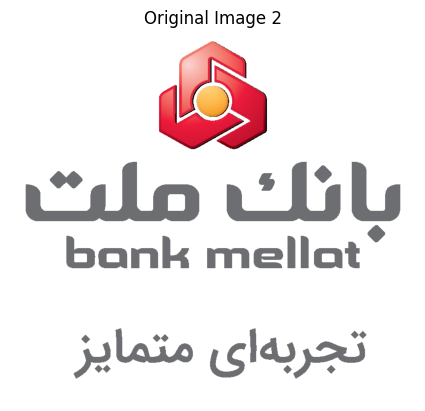

considered picture BM_LOGO-01.png compare with BM_LOGO-04.png
Results:

### PyTorch Models ###
ResNet50 Cosine Similarity: 0.8524
VGG16 Cosine Similarity: 0.9433
EfficientNet_B0 Cosine Similarity: 0.8554
MobileNet Cosine Similarity: 0.8874
ShuffleNet Cosine Similarity: 0.8647
SqueezeNet Cosine Similarity: 0.9878

### TensorFlow Models ###
EfficientNet-Lite Cosine Similarity: 0.7911
SIFT Match Ratio: 0.6390
SSIM Score: 0.6087


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


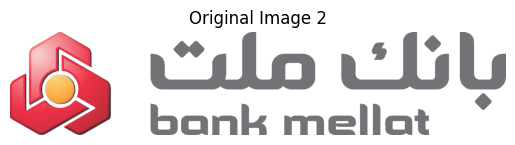

considered picture BM_LOGO-01.png compare with BM_LOGO-05.png
Results:

### PyTorch Models ###
ResNet50 Cosine Similarity: 0.5436
VGG16 Cosine Similarity: 0.6650


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


EfficientNet_B0 Cosine Similarity: 0.5400


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


MobileNet Cosine Similarity: 0.5856
ShuffleNet Cosine Similarity: 0.4769
SqueezeNet Cosine Similarity: 0.9096

### TensorFlow Models ###
EfficientNet-Lite Cosine Similarity: 0.5313


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


SIFT Match Ratio: 0.3838
SSIM Score: 0.3783


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


In [63]:


img1_path = f"/home/mahdi/Phishing_Project/Valid_images/{img1}"
show_image(img1_path, title="Original Image 1")

for i in range(0, len(valid_img)):
    img2_path = f"/home/mahdi/Phishing_Project/Valid_images/{valid_img[i]}"
    show_image(img2_path, title="Original Image 2")
    print(f"considered picture {img1} compare with {valid_img[i]}")
    print('Results:')
    compute_similarity(img1_path, img2_path, pytorch_models, tf_models, pytorch_transform)
    good_matches, kp1, kp2, keypoints1, keypoints2, matches = sift_similarity(img1_path, img2_path)
    print(f"SIFT Match Ratio: {good_matches / min(kp1, kp2):.4f}")
    ssim_score = compute_ssim(img1_path, img2_path)
    print(f"SSIM Score: {ssim_score:.4f}")
    

In [64]:

# compute_similarity(img1_path, img2_path, pytorch_models, tf_models, pytorch_transform)

In [65]:
# ssim_score = compute_ssim(img1_path, img2_path)
# print(f"SSIM Score: {ssim_score:.4f}")


Number of good matches: 103
Keypoints in Image 1: 313, Image 2: 271
SIFT Match Ratio: 0.3801


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


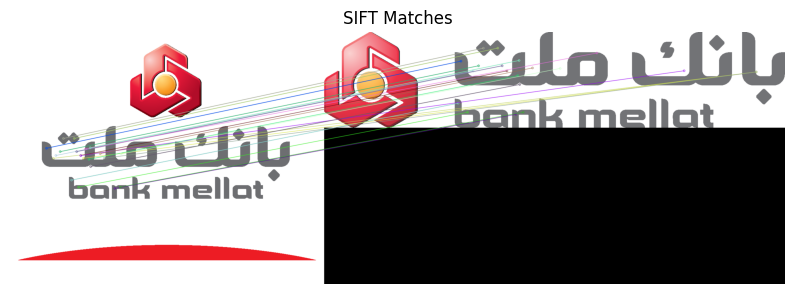

In [66]:
good_matches, kp1, kp2, keypoints1, keypoints2, matches = sift_similarity(img1_path, img2_path)
print(f"Number of good matches: {good_matches}")
print(f"Keypoints in Image 1: {kp1}, Image 2: {kp2}")
print(f"SIFT Match Ratio: {good_matches / min(kp1, kp2):.4f}")
show_sift_matches(img1_path, img2_path, keypoints1, keypoints2, matches)
